In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from matplotlib import patches
import matplotlib.pyplot as plt
from astropy import cosmology
from astropy.io import fits
from astropy import table
import SAGA
from SAGAbg.utils import calc_kcor, functional_forms

In [3]:
from astropy import units as u

In [4]:
plt.rcParams['font.size'] = 16

In [5]:
cosmo = cosmology.FlatLambdaCDM(70.,0.3)

In [7]:
saga = SAGA.QuickStart(local_dir='../local_data/')
#'/path/to/saga/dropbox/folder', '/path/to/saga/local/folder')

saga.database["combined_base"].remote.path = "https://drive.google.com/uc?export=download&id=1WnGUfDCZwXEUsy4zgGFR1ez3ZE5DFtsB&confirm=t&uuid=d0f82ed0-6db5-4ca0-bb8f-6c54d44a17db"

saga.database["combined_base"].download(overwrite=False)

base = saga.object_catalog.load_combined_base_catalog()
base = saga.host_catalog.construct_host_query("paper3").filter(base)

cleaner = (base['REMOVE']==0)&base['is_galaxy']&(base['g_mag']<30.)&(base['r_mag']<30.)#&(base['ZQUALITY']>=3)
clean = base[cleaner]

clean['selection'] = 0
cuts = SAGA.objects.cuts
SAGA.utils.fill_values_by_query(clean, cuts.main_targeting_cuts, {'selection':3})
SAGA.utils.fill_values_by_query(clean, cuts.paper1_targeting_cut&~cuts.main_targeting_cuts, {'selection':2})
SAGA.utils.fill_values_by_query(clean, ~cuts.main_targeting_cuts&~cuts.paper1_targeting_cut, {'selection':1})
#clean = clean.to_pandas ()

SAGA `shared_dir` set to /Users/kadofong/work/surveys/saga/notebooks
SAGA `local_dir`  set to ../local_data/


218845

In [8]:
negative_redshift = clean['SPEC_Z'] < .0005
reassign_zquality = np.zeros_like(clean['ZQUALITY'])
reassign_zquality[~negative_redshift] = clean[~negative_redshift]['ZQUALITY']
clean['ZQUALITY'] = reassign_zquality
#clean.loc[negative_redshift,'ZQUALITY'] = 0

In [9]:
kcorrect = calc_kcor.calc_kcor

distmod = cosmo.distmod(clean['SPEC_Z']).value
real_kcorrect_g = kcorrect ( 'g', clean['SPEC_Z'],'gr', clean['gr'])
clean['Mg'] = clean['g_mag'] - distmod - real_kcorrect_g 
clean["Kg"] = real_kcorrect_g
real_kcorrect_r = kcorrect ( 'r', clean['SPEC_Z'], 'gr', clean['gr'])
clean['Mr'] = clean['r_mag'] - distmod - real_kcorrect_r
clean["Kr"] = real_kcorrect_r
real_kcorrect_z = kcorrect ( 'z', clean['SPEC_Z'], 'rz', clean['rz'])
clean['Mz'] = clean['z_mag'] - distmod - real_kcorrect_z 
clean["Kz"] = real_kcorrect_z

logml = 1.65 * (clean['Mg']-clean['Mr']) - 0.66
clean['cm_logmstar'] = logml + (clean['Mg']-5.11)/-2.5

/opt/miniconda3/envs/cenv/lib/python3.10/site-packages/astropy/cosmology/flrw/lambdacdm.py:347: RuntimeWarning: divide by zero encountered in divide
  self._T_hypergeometric(s / (z2 + 1.0)))
/opt/miniconda3/envs/cenv/lib/python3.10/site-packages/astropy/cosmology/flrw/lambdacdm.py:369: RuntimeWarning: invalid value encountered in multiply
  return 2 * np.sqrt(x) * hyp2f1(1./6, 1./2, 7./6, -x**3)


In [10]:
saga_rlim = 20.75
saga_primary_grcut = lambda gr,u_gr, r: .9 > (gr - u_gr + 0.06*(r-14.)) # must be bluer than <
saga_primary_sbcut = lambda sb_r,u_sb_r, r: 18.5 < (sb_r + u_sb_r - 0.7*(r-14.)) # must be fainter than >
saga_relaxed_grcut = lambda gr,u_gr: (gr - 2.*u_gr) < 0.85
saga_relaxed_rzcut = lambda rz,u_rz: (rz - 2.*u_rz) < 1.

Do a rough backwards k correction before we have the spectra

In [11]:
# \\ for now, estimate reverse K corrections
# \\ using the median K correction as a function of redshift

has_z = clean['ZQUALITY']>=3
zbins = np.linspace(0.,0.5,100)
zmidpts = 0.5*(zbins[1:]+zbins[:-1])
assns = np.digitize(clean[has_z]['SPEC_Z'], zbins)
#assns = assns[~np.in1d(assns,[0,len(zbins)])]

Kcorrz = clean[has_z].to_pandas().groupby(assns).median()[['Kg','Kr','Kz']]
Kcorrz = Kcorrz.loc[1:len(zbins)-1]


In [12]:
# \\ compute what the apparent magnitude should be at a given redshift 
# \\ for each galaxy in g,r,z
# \\ TODO : use the spectra to get an actual reverse K-correction instead of
# \\ this nonsense
appmag = lambda zindex,bandpass: np.asarray(clean[f'M{bandpass}']) + cosmo.distmod(zmidpts[zindex]).value + Kcorrz.loc[zindex+1, f'K{bandpass}']

mgrid = np.zeros([3,len(zmidpts),len(clean)])

bands = ['g','r','z']
for bandindex in range(len(bands)):
    for zindex in range(len(zmidpts)):
        mgrid[bandindex,zindex] = appmag ( zindex, bands[bandindex] )

In [23]:
def angle_difference ( a, b ):
    nonwrapped_diff = a - b
    diff = (nonwrapped_diff + 180.) % 360. - 180.
    return diff

In [32]:
saga_area = 0.
for host in np.unique(base['HOSTID']):
    this_host = base[base['HOSTID']==host].to_pandas ()
    
    if not (~(this_host['RA'] > 180.)).all() and not (this_host['RA'] > 180.).all():
        ra = this_host['RA'].copy ()
        ra[ra>180.] -= 360.
    else:
        ra = this_host['RA']
    radius = np.mean([ra.max() - ra.min(),this_host['DEC'].max() - this_host['DEC'].min(),])/2.
    area = (np.pi * radius**2)
    saga_area += area
skycoverage = ((saga_area*u.deg**2)/(4.*np.pi*u.sr)).decompose ()

In [34]:
# \\ PRIMARY CUT

# \\ r band limit
zindex_rlim = np.sum(mgrid[1] < saga_rlim,axis=0) - 1
zmax_rlim = zmidpts[zindex_rlim]
zmax_rlim[(zindex_rlim<0)|(zindex_rlim==(len(zmidpts)-1))] = np.NaN

# \\ gr limit
gr_at_z = mgrid[0] - mgrid[1]
in_primary_gr_at_z = saga_primary_grcut ( gr_at_z, clean['g_err'], mgrid[1] )
sbfactor = ((1.+np.asarray(clean['SPEC_Z'])[np.newaxis,:])/(1.+zmidpts[:,np.newaxis]))**4
in_primary_sb_at_z = saga_primary_sbcut ( (clean['sb_r'] + mgrid[1] - clean['r_mag'])*sbfactor,
                                            clean['sb_r_err'], mgrid[1] )

# \\ primary weights
zindex_primary_gr = np.argmax(~in_primary_gr_at_z,axis=0)
zindex_primary_sb = np.argmax(~in_primary_sb_at_z,axis=0)

zindex_primary = np.array([zindex_primary_gr, zindex_primary_sb, zindex_rlim])
zindex_primary = np.min(zindex_primary,axis=0)

zmax_primary = zmidpts[zindex_primary]
zmax_primary[zindex_primary<=0] = np.NaN
vmax_primary = cosmo.comoving_volume ( zmax_primary ).value
weights_primary = 1./vmax_primary

weights_maglim = 1./cosmo.comoving_volume(zmidpts[zindex_rlim]).value
weights_primary_sb = 1./cosmo.comoving_volume(zmidpts[zindex_primary_sb]).value
weights_primary_sb[zindex_primary_sb<=0] = np.NaN
weights_primary_gr = 1./cosmo.comoving_volume(zmidpts[zindex_primary_gr]).value
weights_primary_gr[zindex_primary_gr<=0] = np.NaN


In [35]:
from scipy import integrate 

# \\ construct SMF from Panter et al. 2007
mbins = np.linspace(6.,9.5,30)
mass_xs = 0.5*(mbins[1:]+mbins[:-1])

smf_args = (2.2e-3, np.log10(1.005e11), -1.22 )
logm = 0.5*(mbins[1:]+mbins[:-1])
nrml = integrate.quad ( functional_forms.logschechter_alog, 7., 9.6,
                        args=smf_args )[0]
smf_sdss = functional_forms.logschechter_alog(logm, *smf_args )/nrml

# \\ construct SMF from Wright et al. 2017
smf1_args = (2.93e-3, 10.78, -0.62 )
smf2_args = (0.63e-3, 10.78, -1.50 )

dbl_schechter = lambda x: functional_forms.logschechter_alog(x,*smf1_args) + \
                functional_forms.logschechter_alog(x, *smf2_args )
nrml = integrate.quad ( dbl_schechter, 7., 9.6 )[0]
smf_gama = dbl_schechter(logm)/nrml

cc = "#ff5a00"
is_primary = clean['selection']==3
unweighted_counts,_,_=plt.hist(clean[is_primary]['cm_logmstar'], bins=mbins, density=True, color='lightgrey')
#plt.hist(clean[is_primary&np.isfinite(weights)]['cm_logmstar'], weights=weights[is_primary&np.isfinite(weights)], 
#         bins=mbins, density=True, lw=3, histtype='step', color=cc)
unweighted_counts,_=np.histogram ( clean[is_primary&np.isfinite(weights_primary)]['cm_logmstar'], 
                                  bins=mbins)


# \\ COMPONENTS

cc_l = ['#e6ac00','#62bd41','#6a6a6a']
for compindex,component in enumerate([weights_primary_gr,weights_maglim,weights_primary_sb]):
    cts,_=np.histogram ( clean[is_primary&np.isfinite(component)]['cm_logmstar'], 
                         weights=component[is_primary&np.isfinite(component)], 
                         density=True,
                         bins=mbins)    
    plt.plot( mass_xs, cts, 'o', color=cc_l[compindex], markersize=3, alpha=.3)
    
# \\ ACTUAL GUESS AT VMAX CORRECTION
cts,_=np.histogram ( clean[is_primary&np.isfinite(weights_primary)]['cm_logmstar'], 
                     weights=weights_primary[is_primary&np.isfinite(weights_primary)], 
                     density=True,
                     bins=mbins) 
primary_smf = cts.copy ()
plt.errorbar( mass_xs, cts, fmt='o', color=cc, yerr=cts/np.sqrt(unweighted_counts), label='SAGAbg primary')

# \\ GAMA & SDSS COUNTERPARTS
plt.plot ( logm, smf_sdss, color='k', lw=3, ls='--', label='Panter+2007')
plt.plot ( logm, smf_gama, color='k', lw=3, label='Wright+2017')

# \\ COSMETICS
plt.yscale('log')
plt.legend(fontsize=12, loc='lower left')
plt.xlabel(r'$\log_{10}(\rm M_\bigstar/M_\odot)$')
plt.ylabel(r'dN/d$\log_{10}(\rm M_\bigstar/M_\odot)$')
plt.xlim(6.,9.5)

plt.tight_layout ()
plt.savefig('../figures/SAGAbg_primary_smf.png')

In [303]:
from scipy import integrate 

# \\ construct SMF from Panter et al. 2007
#mbins = np.linspace(6.,10.5,25)
mbins = np.concatenate([np.array([6.5]), np.arange(7.25,8.5,0.25), np.arange(8.5, 10.,.2)])
mass_xs = 0.5*(mbins[1:]+mbins[:-1])

smf_args = (2.2e-3, np.log10(1.005e11), -1.22 )
logm = 0.5*(mbins[1:]+mbins[:-1])
smf_sdss = functional_forms.logschechter_alog(mbins, *smf_args )

# \\ construct SMF from Wright et al. 2017
smf1_args = (2.93e-3, 10.78, -0.62 )
smf2_args = (0.63e-3, 10.78, -1.50 )

dbl_schechter = lambda x: functional_forms.logschechter_alog(x,*smf1_args) + \
                functional_forms.logschechter_alog(x, *smf2_args )
smf_gama = dbl_schechter(mbins)

In [304]:
is_primary = clean['selection']==3

# \\ account for changing size of \Delta log_10(M_star)
mass_assns = np.digitize(clean[is_primary&np.isfinite(weights_primary)]['cm_logmstar'], mbins) - 1
mass_assns[(mass_assns<0)|(mass_assns>=(len(mbins)-1))] = -1
massbin_weights = np.diff(mbins)[mass_assns]**-1

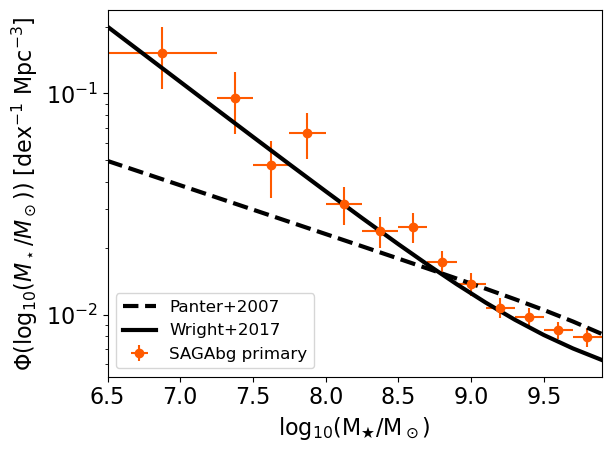

In [305]:
fraction_with_spec =  (clean[is_primary]['ZQUALITY'] >=3).sum() / len(clean[is_primary])
skycoverage = ((saga_area*u.deg**2)/(4.*np.pi*u.sr)).decompose ()

cc = "#ff5a00"
is_primary = clean['selection']==3
#unweighted_counts,_,_=plt.hist(clean[is_primary]['cm_logmstar'], bins=mbins, density=True, color='lightgrey')
#plt.hist(clean[is_primary&np.isfinite(weights)]['cm_logmstar'], weights=weights[is_primary&np.isfinite(weights)], 
#         bins=mbins, density=True, lw=3, histtype='step', color=cc)
unweighted_counts,_=np.histogram ( clean[is_primary&np.isfinite(weights_primary)]['cm_logmstar'], 
                                  bins=mbins)



# \\ ACTUAL GUESS AT VMAX CORRECTION
coverage_factor = (fraction_with_spec * skycoverage)**-1
cts,_=np.histogram ( clean[is_primary&np.isfinite(weights_primary)]['cm_logmstar'], 
                     weights=weights_primary[is_primary&np.isfinite(weights_primary)]*massbin_weights*coverage_factor, 
                     bins=mbins) 
primary_smf = np.array([cts, cts/np.sqrt(unweighted_counts)])
primary_massbins = np.array([mass_xs.copy(), np.diff(mbins)/2.])
primary_color = cc
plt.errorbar( mass_xs, cts, fmt='o', color=cc, 
             xerr = np.diff(mbins)/2.,
             yerr=3.*cts/np.sqrt(unweighted_counts), label='SAGAbg primary',)

# \\ GAMA & SDSS COUNTERPARTS
plt.plot ( mbins, smf_sdss, color='k', lw=3, ls='--', label='Panter+2007')
plt.plot ( mbins, smf_gama, color='k', lw=3, label='Wright+2017')

# \\ COSMETICS
plt.yscale('log')
plt.legend(fontsize=12, loc='lower left')
plt.xlabel(r'$\log_{10}(\rm M_\bigstar/M_\odot)$')
plt.ylabel(r'$\Phi(\log_{10}(M_\star/M_\odot))$ [dex$^{-1}$ Mpc$^{-3}$]')
plt.xlim(mbins.min(),mbins.max())

plt.tight_layout ()
plt.savefig('../figures/SAGAbg_primary_absSMF.png')

In [306]:
primary_savearr = np.array([primary_massbins, primary_smf])
np.save ( '../local_data/scratch/primary_smf.npy', primary_savearr )

In [312]:
rphys = (clean['radius'] * u.arcsec * cosmo.kpc_proper_per_arcmin ( clean['SPEC_Z'] )).to(u.kpc).value

array([0.37153523, 0.39170506, 0.41296987, 0.4353891 , 0.45902542,
       0.4839449 , 0.51021721, 0.53791578, 0.56711805, 0.59790564,
       0.63036463, 0.66458574, 0.70066465, 0.73870219, 0.77880471,
       0.82108431, 0.86565918, 0.91265392, 0.9621999 , 1.01443562,
       1.0695071 , 1.1275683 , 1.18878151, 1.25331785, 1.32135773,
       1.39309134, 1.46871921, 1.54845276, 1.63251486, 1.72114051,
       1.81457745, 1.91308688, 2.01694417, 2.12643965, 2.24187939,
       2.36358611, 2.49190001, 2.6271798 , 2.76980363, 2.92017019,
       3.07869982, 3.24583568, 3.42204498, 3.6078203 , 3.80368095,
       4.01017445, 4.22787802, 4.45740025, 4.69938273, 4.95450191])

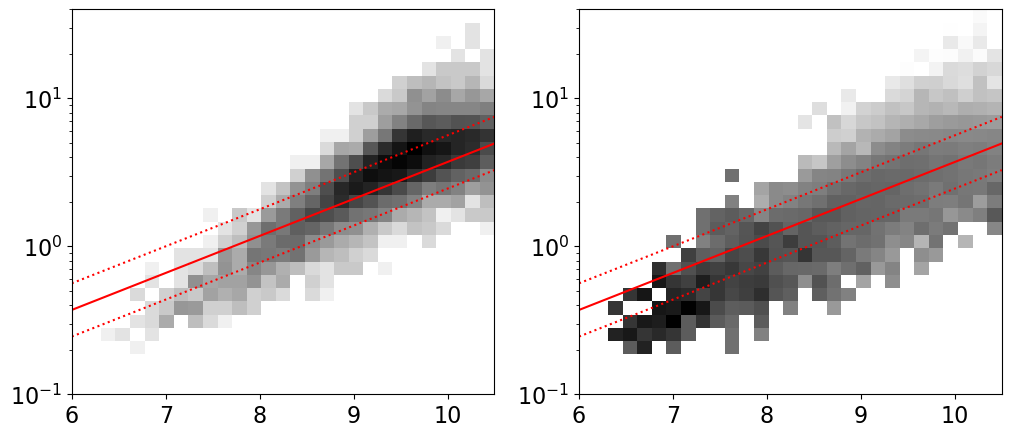

In [342]:
from matplotlib.colors import LogNorm

fig, axarr = plt.subplots(1,2,figsize=(12,5))


pmask = is_primary&np.isfinite(weights_primary)
axarr[0].hist2d ( clean[pmask]['cm_logmstar'], 
             rphys[pmask], 
             #weights=weights_primary[pmask],
             bins=[np.linspace(6.,10.5,30), np.logspace(-1,np.log10(40),30)],
             cmap='Greys', 
             norm=LogNorm())
axarr[1].hist2d ( clean[pmask]['cm_logmstar'], 
             rphys[pmask], 
             weights=weights_primary[pmask],
             bins=[np.linspace(6.,10.5,30), np.logspace(-1,np.log10(40),30)],
             cmap='Greys', 
             norm=LogNorm())


xs = np.linspace(6.,10.5,50)
ckwargs = {'color':'r'}
for ax in axarr:
    ax.plot ( xs, 10.**(0.25*xs + 1.07)/1e3, **ckwargs )
    ax.plot ( xs, 10.**(0.25*xs + 1.07 + 0.18)/1e3, ls=':', **ckwargs )
    ax.plot ( xs, 10.**(0.25*xs + 1.07 - 0.18)/1e3, ls=':', **ckwargs )
    ax.set_yscale('log')

In [237]:
# hmm, but the masses go wonky at "high"-z, so can we use z(M*) as a cut?

In [238]:
# \\ RELAXED CUT
hard_zlim = 0.15
is_relaxed = (clean['selection']>=2)&(clean['SPEC_Z']<hard_zlim)
is_relaxed_phot = clean['selection'] >= 2
zcut = clean['SPEC_Z']<hard_zlim
has_specz = clean['ZQUALITY'] >= 3

in_relaxed_gr_at_z = saga_relaxed_grcut ( gr_at_z, clean['g_err'] )
in_relaxed_rz_at_z = saga_relaxed_rzcut ( mgrid[1] - mgrid[2], clean['r_err'] )

zindex_relaxed_gr = np.argmax(~in_relaxed_gr_at_z,axis=0)
zindex_relaxed_rz = np.argmax(~in_relaxed_rz_at_z,axis=0)

zindex_relaxed = np.array([zindex_rlim, zindex_relaxed_gr, zindex_relaxed_rz])
zindex_relaxed = np.min(zindex_relaxed,axis=0)
zmax_relaxed = zmidpts[zindex_relaxed]
zmax_relaxed[zindex_relaxed<=0] = np.NaN
zmax_relaxed[zmax_relaxed>hard_zlim] = hard_zlim # \\ strict redshift cut
weights_relaxed = 1./cosmo.comoving_volume(zmax_relaxed).value

In [277]:
# \\ try un-normalized

# \\ construct SMF from Panter et al. 2007
mbins = np.concatenate([np.array([6.5]), np.arange(7.25,8.5,0.25), np.arange(8.5, 10.,.2)])

mass_assns = np.digitize(clean[is_relaxed&np.isfinite(weights_relaxed)]['cm_logmstar'], mbins) - 1
mass_assns[(mass_assns<0)|(mass_assns>=(len(mbins)-1))] = -1
massbin_weights = np.diff(mbins)[mass_assns]**-1

mass_xs = 0.5*(mbins[1:]+mbins[:-1])

smf_args = (2.2e-3, np.log10(1.005e11), -1.22 )
logm = 0.5*(mbins[1:]+mbins[:-1])
smf_sdss = functional_forms.logschechter_alog(mbins, *smf_args )

# \\ construct SMF from Wright et al. 2017
smf1_args = (2.93e-3, 10.78, -0.62 )
smf2_args = (0.63e-3, 10.78, -1.50 )

dbl_schechter = lambda x: functional_forms.logschechter_alog(x,*smf1_args) + \
                functional_forms.logschechter_alog(x, *smf2_args )
smf_gama = dbl_schechter(mbins)

In [240]:

# \\ try to account for spectroscopic coverage
# \\ things in primary selection have a much higher spectroscopic coverage
# \\ than objects outside of primary but inside the relaxed cut
fraction_with_spec_inprimary = (clean[is_primary&is_relaxed]['ZQUALITY']>=3).sum() 
fraction_with_spec_inprimary /= len(clean[is_primary&is_relaxed]) # \\ fraction of galaxies in primary that have a spec-z
#fraction_inzlim_inprimary = len(clean[is_primary&zcut]) / len(clean[is_primary&has_specz]) # \\ fraction of primary targets that are outside of z cut

# \\ now do the same with the relaxed cut targets
fraction_with_spec_notprimary = (clean[is_relaxed&~is_primary]['ZQUALITY']>=3).sum() 
fraction_with_spec_notprimary /= len(clean[is_relaxed_phot&~is_primary])
#fraction_inzlim_notprimary = len(clean[is_relaxed_phot&~is_primary&zcut]) 
#fraction_inzlim_notprimary /= len(clean[is_relaxed_phot&~is_primary&has_specz])


In [244]:
def bin_by_mass ( catalog, mask, mass_bins, stellarmass_key='cm_logmstar' ):
    mass_assns = np.digitize(catalog[mask][stellarmass_key], mass_bins) - 1
    mass_assns[(mass_assns<0)|(mass_assns>=(len(mass_bins)-1))] = -1  
    return mass_assns
    
def assign_zlim_weights ( catalog, mask, mass_bins, zlimit, specz_key = 'SPEC_Z', zquality_key='ZQUALITY', return_fraction=False,**kwargs ):
    mass_assns = bin_by_mass ( catalog, mask, mass_bins,**kwargs )
    fraction_in_redshiftrange = np.zeros(mass_bins.size-1)
    for ma in np.arange(0, mass_bins.size-1):
        n_outofzlimit = (catalog[mask][mass_assns==ma][specz_key] > zlimit).sum()
        n_totalwithspec = (catalog[mask][mass_assns==ma][zquality_key] >= 3.).sum()
        fraction_in_redshiftrange[ma] = 1. - n_outofzlimit / n_totalwithspec
        #print(ma, n_outofzlimit, n_totalwithspec)
    zweights = fraction_in_redshiftrange[mass_assns]
    if return_fraction:
        return fraction_in_redshiftrange
    return zweights
    #(clean[is_relaxed&np.isfinite(weights_relaxed)][mass_assns==1]['SPEC_Z'] > hard_zlim).sum()

In [270]:
magbins = np.arange(14.,21.5,.5)
#assign_zlim_weights ( clean, is_primary&np.isfinite(weights_relaxed), magbins, hard_zlim, return_fraction=True, stellarmass_key='r_mag')
#assign_zlim_weights ( clean, is_relaxed_phot&np.isfinite(weights_relaxed), magbins, hard_zlim, return_fraction=True, stellarmass_key='r_mag')

zweights_primary = assign_zlim_weights ( clean, is_primary&np.isfinite(weights_relaxed), mbins, hard_zlim, )# stellarmass_key='r_mag' )
zweights_relaxed = assign_zlim_weights ( clean, is_relaxed_phot&np.isfinite(weights_relaxed), mbins, hard_zlim,)# stellarmass_key='r_mag')

zweights = np.zeros(len(clean), dtype=float)
zweights[is_relaxed_phot&np.isfinite(weights_relaxed)] = zweights_relaxed
zweights[is_primary&np.isfinite(weights_relaxed)] = zweights_primary

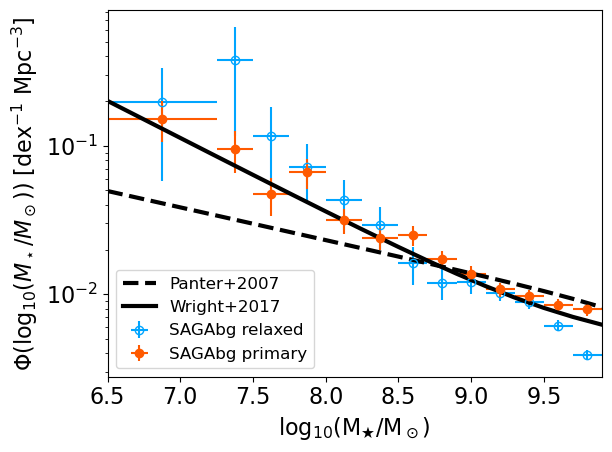

In [278]:
cc = "#00A5FF"

spec_weights = np.ones(len(clean), dtype=float)
spec_weights[is_primary&is_relaxed] = fraction_with_spec_inprimary 
spec_weights[is_relaxed&~is_primary] = fraction_with_spec_notprimary 

unweighted_counts,_=np.histogram ( clean[is_relaxed&np.isfinite(weights_relaxed)]['cm_logmstar'], 
                                  bins=mbins)

    
# \\ ACTUAL GUESS AT VMAX CORRECTION
spec_factor = (zweights/spec_weights)[is_relaxed&np.isfinite(weights_relaxed)]

cts,_=np.histogram ( clean[is_relaxed&np.isfinite(weights_relaxed)]['cm_logmstar'], 
                     weights=weights_relaxed[is_relaxed&np.isfinite(weights_relaxed)] * spec_factor * massbin_weights / skycoverage, 
                     #density=True,
                     bins=mbins)  

plt.errorbar( mass_xs, cts, fmt='o', 
              xerr = np.diff(mbins)/2.,             
              yerr=3.*cts/np.sqrt(unweighted_counts), 
              markeredgecolor = cc,
              markerfacecolor ="None",
              ecolor=cc,
              label='SAGAbg relaxed')
plt.errorbar ( primary_massbins[0], primary_smf[0], 
               xerr = primary_massbins[1],
               color=primary_color, fmt='o', yerr=3.*primary_smf[1], label='SAGAbg primary' )

# \\ GAMA & SDSS COUNTERPARTS
plt.plot ( mbins, smf_sdss, color='k', lw=3, ls='--', label='Panter+2007')
plt.plot ( mbins, smf_gama, color='k', lw=3, label='Wright+2017')

# \\ COSMETICS
plt.yscale('log')
plt.legend(fontsize=12, loc='lower left')
plt.xlabel(r'$\log_{10}(\rm M_\bigstar/M_\odot)$')
plt.ylabel(r'$\Phi(\log_{10}(M_\star/M_\odot))$ [dex$^{-1}$ Mpc$^{-3}$]')
plt.xlim(mbins.min(),mbins.max())

plt.tight_layout ()
plt.savefig('../figures/SAGAbg_relaxed_absSMF.png')

# quenching?

In [287]:
pmask =is_primary&np.isfinite(weights_primary)

OBJID,RA,DEC,REMOVE,is_galaxy,morphology_info,radius,radius_err,ba,phi,sma,REF_CAT,SGA_ID,EBV,SERSIC,u_mag,g_mag,r_mag,i_mag,z_mag,u_err,g_err,r_err,i_err,z_err,w1_mag,w2_mag,w3_mag,w4_mag,w1_err,w2_err,w3_err,w4_err,g_fibermag,r_fibermag,z_fibermag,g_fibertotmag,r_fibertotmag,z_fibertotmag,survey,OBJID_decals,REMOVE_decals,HOSTID,HOST_PGC,HOST_NSAID,HOST_NSA1ID,HOST_SAGA_NAME,HOST_RA,HOST_DEC,HOST_DIST,HOST_VHOST,HOST_ZCOSMO,HOST_MK,HOST_COMMON_NAME,RHOST_ARCM,RHOST_KPC,SPEC_Z,SPEC_Z_ERR,ZQUALITY,SPECOBJID,MASKNAME,TELNAME,HELIO_CORR,OBJ_NSAID,SPEC_REPEAT,SPEC_REPEAT_ALL,RA_spec,DEC_spec,OBJ_PGC,EW_Halpha,EW_Halpha_err,RA_nuv,DEC_nuv,nuv_mag,nuv_err,RA_fuv,DEC_fuv,fuv_mag,fuv_err,nuv_snr,nuv_sfr,nuv_sfr_flag,SATS,sb_r,sb_r_err,z_cosmo,Mr,log_sm,spec_phot_sep,quenched,ug,ug_err,gr,gr_err,ri,ri_err,iz,iz_err,rz,rz_err,human_selected,p_sat_model_p2,p_sat_model_p3,p_sat_corrected,selection,Mg,Kg,Kr,Mz,Kz,cm_logmstar
int64,float64,float64,int32,bool,int32,float32,float32,float32,float32,float32,str2,int64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,str6,int64,int32,str48,int32,int32,int32,str48,float32,float32,float32,float32,float32,float32,str48,float32,float32,float32,float32,int32,str48,str48,str6,bool,int32,str48,str48,float64,float64,int64,float32,float32,float64,float64,float32,float32,float64,float64,float32,float32,float32,float32,int32,int32,float32,float32,float32,float64,float32,float32,int32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float32,float32,float32,int64,float64,float32,float32,float64,float32,float64
904488140000000457,0.5595432471056097,21.001713458182465,0,True,264,1.5209833,0.016233295,0.7396426,-87.59958,5.305603,,-1,0.05739044,1.0,99.0,20.769361,20.351278,99.0,20.131292,99.0,0.014554424,0.01626491,99.0,0.02836599,20.59669,20.894506,99.0,14.611887,0.115480036,0.32149294,0.42991847,0.2396813,22.712769,22.294685,22.074701,22.712759,22.294678,22.074696,decals,904488140000000457,0,nsa126115,279,126115,613769,Bandamanna,0.995382,20.752356,32.352436,2309.4,0.007509266,-24.1363,NGC7817,28.650282,269.62305,0.23361495,9e-06,4,11,spHect-mmt_nsa126115_2020.1010_1.zlog,MMT,True,-1,MMT,MMT,0.5595450150000001,21.001707077,-1,nan,nan,0.5591770822445471,21.00171424379129,22.61103,0.42419398,0.5591770822445471,21.00171424379129,22.078638,0.3888638,nan,nan,-1,0,23.25735,0.028313767,0.23399808,-19.821739335733177,9.647596,0.023728201,-1,78.23064,99.0,0.4180832,0.021826098,-78.64872,99.0,78.868706,99.00001,0.21998596,0.032698266,0,0.0005230327,0.009146439,0.0,3,-19.59567824490619,0.029727817,-0.16229428,-20.027835835891487,-0.17618375,9.595272097827007
904488140000000504,0.5619601333499491,20.94450994145093,0,True,800,2.0810406,0.0026005663,0.6233225,-76.27367,7.9076138,,-1,0.05829769,0.75021094,99.0,18.60139,17.997597,99.0,17.538303,99.0,0.0033834164,0.0029610645,99.0,0.0035917708,17.766129,18.136417,16.76342,14.010268,0.010916541,0.029022213,0.23379903,0.14708446,21.176136,20.57234,20.113049,21.176136,20.57234,20.113049,decals,904488140000000504,0,nsa126115,279,126115,613769,Bandamanna,0.995382,20.752356,32.352436,2309.4,0.007509266,-24.1363,NGC7817,26.898691,253.13943,0.1407684,9e-06,4,153,spHect-nsa126115_2018.0918_1.zlog,MMT,True,-1,MMT,MMT,0.561974985,20.944564819,-1,nan,nan,0.5619459220973194,20.94428722427836,20.711367,0.23494779,0.5619459220973194,20.94428722427836,21.68871,0.3717201,nan,nan,-1,0,21.58445,0.0040163896,0.14115068,-21.115238253038385,10.367954,0.20377183,-1,80.398605,99.0,0.6037941,0.004496155,-81.0024,99.0,81.4617,99.0,0.45929337,0.004654967,0,0.001523397,0.006821157,0.0,3,-20.598027836542585,0.08399131,-0.00259237,-21.531049825262286,-0.046074163,10.476608321835103
904488140000003873,0.7616671162469209,20.96577703596269,0,True,800,2.1705859,0.013080734,0.6090905,-69.34133,8.343674,,-1,0.06309776

In [280]:
x = np.random.normal(0.,1., 10000)

In [282]:
(x<-1.5).sum() / 10000

0.0682

In [283]:
(abs(x)>1.5).sum() / 10000

0.1398

In [183]:
# \\ construct SMF from Panter et al. 2007
mbins = np.linspace(7.5,9.5,30)
mass_xs = 0.5*(mbins[1:]+mbins[:-1])

smf_args = (2.2e-3, np.log10(1.005e11), -1.22 )
logm = 0.5*(mbins[1:]+mbins[:-1])
nrml = integrate.quad ( functional_forms.logschechter_alog, 7., 9.6,
                        args=smf_args )[0]
smf_sdss = functional_forms.logschechter_alog(logm, *smf_args )/nrml

# \\ construct SMF from Wright et al. 2017
smf1_args = (2.93e-3, 10.78, -0.62 )
smf2_args = (0.63e-3, 10.78, -1.50 )

dbl_schechter = lambda x: functional_forms.logschechter_alog(x,*smf1_args) + \
                functional_forms.logschechter_alog(x, *smf2_args )
nrml = integrate.quad ( dbl_schechter, 7., 9.6 )[0]
smf_gama = dbl_schechter(logm)/nrml

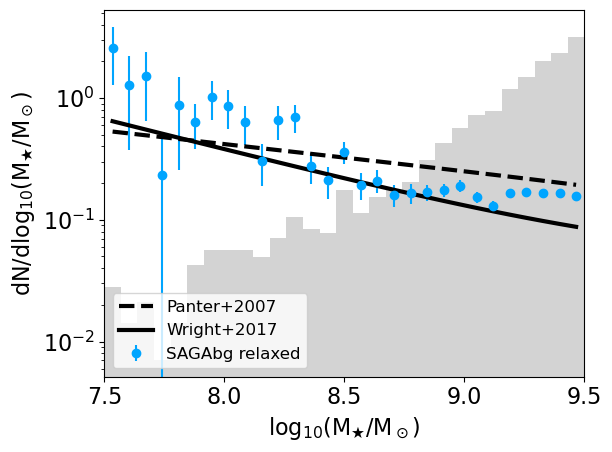

In [184]:
cc = "#00A5FF"
is_relaxed = clean['selection']==2
plt.hist(clean[is_relaxed&np.isfinite(weights_relaxed)]['cm_logmstar'], bins=mbins, density=True, color='lightgrey')
#plt.hist(clean[is_relaxed&np.isfinite(weights)]['cm_logmstar'], weights=weights[is_relaxed&np.isfinite(weights)], 
#         bins=mbins, density=True, lw=3, histtype='step', color=cc)
unweighted_counts,_=np.histogram ( clean[is_relaxed&np.isfinite(weights_relaxed)]['cm_logmstar'], 
                                  bins=mbins)

    
# \\ ACTUAL GUESS AT VMAX CORRECTION
cts,_=np.histogram ( clean[is_relaxed&np.isfinite(weights_relaxed)]['cm_logmstar'], 
                     weights=weights_relaxed[is_relaxed&np.isfinite(weights_relaxed)], 
                     density=True,
                     bins=mbins)    
plt.errorbar( mass_xs, cts, fmt='o', color=cc, yerr=cts/np.sqrt(unweighted_counts), label='SAGAbg relaxed')

# \\ GAMA & SDSS COUNTERPARTS
plt.plot ( logm, smf_sdss, color='k', lw=3, ls='--', label='Panter+2007')
plt.plot ( logm, smf_gama, color='k', lw=3, label='Wright+2017')

# \\ COSMETICS
plt.yscale('log')
plt.legend(fontsize=12, loc='lower left')
plt.xlabel(r'$\log_{10}(\rm M_\bigstar/M_\odot)$')
plt.ylabel(r'dN/d$\log_{10}(\rm M_\bigstar/M_\odot)$')
plt.xlim(mbins.min(),mbins.max())

plt.tight_layout ()
plt.savefig('../figures/SAGAbg_relaxed_smf.png')